In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, color, data
from skimage.morphology import erosion, dilation
import random
import os
import numpy as np
import pandas as pd
import cv2
import math
import argparse

E:\Anaconda\envs\bosch_env\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
E:\Anaconda\envs\bosch_env\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
E:\Anaconda\envs\bosch_env\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [79]:
parser = argparse.ArgumentParser(description='Distance to the center of the lane')
parser.add_argument("car_position")
parser.add_argument('--images', '--i', help='computes distance to the center of the lane and the relative angle for input images')
args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--images IMAGES] lane_center_dist
ipykernel_launcher.py: error: unrecognized arguments: -f


SystemExit: 2

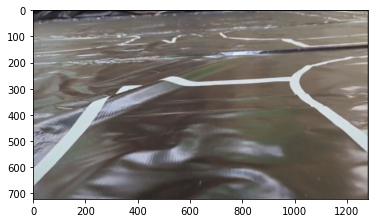

In [18]:
image = io.imread('images/test_image_9.png')
plt.imshow(image)

In [2]:
# define constants
# horizontal_dim = image.shape[1]
bright_high = 180
bright_low = 160
normal = 110
normal_low = 70
dark_high = 45
dark_low = 35
car_direction = np.pi / 2

In [3]:
# to draw lines on the image
def add_weights(image, initial_image, alpha=0.8, beta=1, lambd=0):
    weighted_image = cv2.addWeighted(initial_image, alpha, image, beta, lambd)
    return weighted_image

In [4]:
# to get the lanes on the region of interest
def get_region_of_interest(edges, vertices):
    img = np.zeros_like(edges)
    if len(edges.shape) > 2:
        mask_color_ignore = (255, ) * edges.shape[2]
    else:
        mask_color_ignore = 255
    cv2.fillPoly(img, vertices, mask_color_ignore)
    masked_image = cv2.bitwise_and(edges, img)
#     io.imshow(img)
    return masked_image

In [5]:
# to make lines out of identified edges
def get_hough_lines(image, rho, theta, treshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(image, rho, theta, treshold, np.array([]), minLineLength=min_line_len, 
                           maxLineGap = max_line_gap)
    line_img = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
    m_lines = process_lines(lines)
    merged_lines = []
    for line in m_lines:
        merged_lines.append([[line[0][0], line[0][1], line[1][0], line[1][1]]])
    merged_lines = np.array(merged_lines)
    # here the merge for multiple lines is run and I output their coordinates
    # print('Merged lines:', merged_lines)
    car_offset, angle = draw_lines(line_img, merged_lines)
    return line_img, car_offset, angle

In [6]:
# here starts code for line merging
def get_lines(lines_in):
    return [l[0] for l in lines_in]

def process_lines(lines):
    for line in get_lines(lines):
        leftx, boty, rightx, topy = line
    _lines = []
    for _line in get_lines(lines):
        _lines.append([(_line[0], _line[1]),(_line[2], _line[3])])
        
    # sort
    _lines_x = []
    _lines_y = []
    for line_i in _lines:
        orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))
        if (abs(math.degrees(orientation_i)) > 45) and abs(math.degrees(orientation_i)) < (90+45):
            _lines_y.append(line_i)
        else:
            _lines_x.append(line_i)
            
    _lines_x = sorted(_lines_x, key=lambda _line: _line[0][0])
    _lines_y = sorted(_lines_y, key=lambda _line: _line[0][1])
        
    merged_lines_x = merge_lines_pipeline_2(_lines_x)
    merged_lines_y = merge_lines_pipeline_2(_lines_y)
    
    merged_lines_all = []
    merged_lines_all.extend(merged_lines_x)
    merged_lines_all.extend(merged_lines_y)
    return merged_lines_all

In [7]:
def merge_lines_pipeline_2(lines):
    super_lines_final = []
    super_lines = []
    min_distance_to_merge = 30
    min_angle_to_merge = 30
    
    for line in lines:
        create_new_group = True
        group_updated = False

        for group in super_lines:
            for line2 in group:
                if get_distance(line2, line) < min_distance_to_merge:
                    # check the angle between lines       
                    orientation_i = math.atan2((line[0][1]-line[1][1]),(line[0][0]-line[1][0]))
                    orientation_j = math.atan2((line2[0][1]-line2[1][1]),(line2[0][0]-line2[1][0]))

                    if int(abs(abs(math.degrees(orientation_i)) - abs(math.degrees(orientation_j)))) < min_angle_to_merge: 
                        #print("angles", orientation_i, orientation_j)
                        #print(int(abs(orientation_i - orientation_j)))
                        group.append(line)

                        create_new_group = False
                        group_updated = True
                        break
            
            if group_updated:
                break

        if (create_new_group):
            new_group = []
            new_group.append(line)

            for idx, line2 in enumerate(lines):
                # check the distance between lines
                if get_distance(line2, line) < min_distance_to_merge:
                    # check the angle between lines       
                    orientation_i = math.atan2((line[0][1]-line[1][1]),(line[0][0]-line[1][0]))
                    orientation_j = math.atan2((line2[0][1]-line2[1][1]),(line2[0][0]-line2[1][0]))

                    if int(abs(abs(math.degrees(orientation_i)) - abs(math.degrees(orientation_j)))) < min_angle_to_merge: 
                        #print("angles", orientation_i, orientation_j)
                        #print(int(abs(orientation_i - orientation_j)))

                        new_group.append(line2)

                        # remove line from lines list
                        #lines[idx] = False
            # append new group
            super_lines.append(new_group)
        
    
    for group in super_lines:
        super_lines_final.append(merge_lines_segments1(group))
    
    return super_lines_final

In [8]:
def merge_lines_segments1(lines, use_log=False):
    if(len(lines) == 1):
        return lines[0]
    
    line_i = lines[0]
    
    # orientation
    orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))
    
    points = []
    for line in lines:
        points.append(line[0])
        points.append(line[1])
        
    if (abs(math.degrees(orientation_i)) > 45) and abs(math.degrees(orientation_i)) < (90+45):
        
        #sort by y
        points = sorted(points, key=lambda point: point[1])
        
        if use_log:
            print("use y")
    else:
        
        #sort by x
        points = sorted(points, key=lambda point: point[0])
        
        if use_log:
            print("use x")
    
    return [points[0], points[len(points)-1]]

In [9]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
# https://stackoverflow.com/questions/32702075/what-would-be-the-fastest-way-to-find-the-maximum-of-all-possible-distances-betw
def lines_close(line1, line2):
    dist1 = math.hypot(line1[0][0] - line2[0][0], line1[0][0] - line2[0][1])
    dist2 = math.hypot(line1[0][2] - line2[0][0], line1[0][3] - line2[0][1])
    dist3 = math.hypot(line1[0][0] - line2[0][2], line1[0][0] - line2[0][3])
    dist4 = math.hypot(line1[0][2] - line2[0][2], line1[0][3] - line2[0][3])
    
    if (min(dist1,dist2,dist3,dist4) < 100):
        return True
    else:
        return False

In [10]:
def lineMagnitude (x1, y1, x2, y2):
    lineMagnitude = math.sqrt(math.pow((x2 - x1), 2)+ math.pow((y2 - y1), 2))
    return lineMagnitude

In [11]:
def DistancePointLine(px, py, x1, y1, x2, y2):
    #http://local.wasp.uwa.edu.au/~pbourke/geometry/pointline/source.vba
    LineMag = lineMagnitude(x1, y1, x2, y2)
    if LineMag < 0.00000001:
        DistancePointLine = 9999
        return DistancePointLine
    u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
    u = u1 / (LineMag * LineMag)
    if (u < 0.00001) or (u > 1):
        #// closest point does not fall within the line segment, take the shorter distance
        #// to an endpoint
        ix = lineMagnitude(px, py, x1, y1)
        iy = lineMagnitude(px, py, x2, y2)
        if ix > iy:
            DistancePointLine = iy
        else:
            DistancePointLine = ix
    else:
        # Intersecting point is on the line, use the formula
        ix = x1 + u * (x2 - x1)
        iy = y1 + u * (y2 - y1)
        DistancePointLine = lineMagnitude(px, py, ix, iy)
    return DistancePointLine

In [12]:
def get_distance(line1, line2):
    dist1 = DistancePointLine(line1[0][0], line1[0][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist2 = DistancePointLine(line1[1][0], line1[1][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist3 = DistancePointLine(line2[0][0], line2[0][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])
    dist4 = DistancePointLine(line2[1][0], line2[1][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])
    
    
    return min(dist1,dist2,dist3,dist4)

In [13]:
# the coordinates for the line are calculated and drawn on the image
def draw_lines(image, lines, color=(255, 0, 0), thickness=10):
    left_slope, right_slope = [], []
    left_lane, right_lane = [], []
    first_shape = image.shape[0]
    test_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            if slope > 0.4:
                right_slope.append(slope)
                right_lane.append(line)
            elif slope < -0.4:
                left_slope.append(slope)
                left_lane.append(line)
            first_shape = min(y1, y2, first_shape)
    if (len(left_lane) == 0) or (len(right_lane) == 0):
        print('No lane detected')
        return 1
    slope_mean_left = np.mean(left_slope, axis=0)
    slope_mean_right = np.mean(right_slope, axis=0)
    mean_left = np.mean(np.array(left_lane), axis=0)
    mean_right = np.mean(np.array(right_lane), axis=0)
    if (slope_mean_left == 0) or (slope_mean_right == 0):
        print('Not possible dividing by zero')
        return 1
# There was a code to calculate x coordinates in case of 2 lines are identified (the middle of the lane),
# but since the line are merged, only 2 of them exists and I get the coordinates there
#     x1_left = abs(int((first_shape - mean_left[0][1] - (slope_mean_left * mean_left[0][0])) / 
#                       slope_mean_left))
#     x2_left = abs(int((first_shape - mean_left[0][1] - (slope_mean_left * mean_left[0][0])) / 
#                       slope_mean_left))
#     x1_right = abs(int((first_shape - mean_right[0][1] - (slope_mean_right * mean_right[0][0])) / 
#                        slope_mean_right))
#     x2_right = abs(int((first_shape - mean_right[0][1] - (slope_mean_right * mean_right[0][0])) / 
#                        slope_mean_right))
    # just print the coordinates of resultant lines
#     print(left_lane, right_lane)
    x1_left = np.int_(left_lane[0][0][0])
    x2_left = np.int_(left_lane[0][0][2])
    x1_right = np.int_(right_lane[0][0][0])
    x2_right = np.int_(right_lane[0][0][2])
    
#     print(first_shape, x1_left, x1_right, x2_left, x2_right)
#     print(mean_left, mean_right, slope_mean_left, slope_mean_right)
    if x1_left < x1_right:
        x1_left = int((x1_left + x1_right) / 2)
        x1_right = x1_left
        y2_left = y2_right = image.shape[0]
        y1_left = int((slope_mean_left * x1_left) + mean_left[0][1] - (slope_mean_left * mean_left[0][0]))
        y1_right = int((slope_mean_right * x1_right) + mean_right[0][1] - (slope_mean_right * mean_right[0][0]))
        y2_left = int((slope_mean_left * x2_left) + mean_left[0][1] - (slope_mean_left * mean_left[0][0]))
        y2_right = int((slope_mean_right * x2_right) + mean_right[0][1] - (slope_mean_right * mean_right[0][0]))
    else:
        y1_left = first_shape
        y1_right = first_shape
        y2_left = first_shape
        y2_right = first_shape
        
    x_middle = (x2_right - x2_left) / 2 + x2_left
    angle = (abs(np.arctan2(y2_right - y1_right, x2_right - x1_right)) + 
            abs(np.arctan2(y2_left - y1_left, x2_left - x1_left))) / 2
    
    new_image = np.array([x1_left, y1_left, x2_left, y2_left, x1_right, y1_right, x2_right, y2_right], dtype="float32")
    # just to know final lines coordinates
#     print(x1_left, y1_left, x2_left, y2_left, x1_right, y1_right, x2_right, y2_right)
#     print('X_bottom', x2_right, x2_left, x2_right - x2_left)
    car_offset = np.int_(np.int_(image.shape[1])) / 2 - x_middle
#     print('Car_offset:', car_offset, 'px')
    cv2.line(image, (int(new_image[0]), int(new_image[1])), (int(new_image[2]), int(new_image[3])), color, thickness)
    cv2.line(image, (int(new_image[4]), int(new_image[5])), (int(new_image[6]), int(new_image[7])), color, thickness)
    cv2.circle(image, (int(x_middle), image.shape[0] - 20), radius=10, color=(0, 255, 0), thickness=-1)
    return car_offset, angle

In [33]:
def find_line_lane(image):
    # transform to gray scale and hue scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_gray_image = cv2.GaussianBlur(gray_image, (5, 5), 3) 
#     io.imshow(t_image)
    
    # first version, mask gray_image
#     white_mask = cv2.inRange(blur_gray_image, 170, 255)
#     masked_image = cv2.bitwise_and(blur_gray_image, white_mask)
#     blur_gray_image = cv2.GaussianBlur(blur_gray_image, (5, 5), 0)

    # second version, OTSU treshold
#     ret, t_image = cv2.threshold(blur_gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    

    # thirs version, hsv mask
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_white = np.array([0, 0, bright_low], dtype=np.uint8)
    upper_white = np.array([80, 80, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv_image, lower_white, upper_white)
    t_image = cv2.bitwise_and(image, image, mask=mask)
#     io.imshow(t_image)

#     dilation
#     dilated_image = dilation(t_image)
#     eroded_image = erosion(dilated_image)

    # identify edges
    canny_edges = cv2.Canny(t_image, 50, 150, apertureSize=3)
#     kernel = np.ones((7, 7), np.uint8)
#     canny_edges = cv2.dilate(canny_edges, kernel, iterations=1)
#     canny_edges = cv2.erode(canny_edges, kernel, iterations=1)
#     io.imshow(canny_edges)
    
    # limit the zone of interest
#     imshape = image.shape
#     lower_left = [0, imshape[0]]
#     lower_right = [imshape[1], imshape[0]]
#     top_left = [imshape[1] / 2 - imshape[1] / 3, imshape[0] / 1.75 + imshape[0] / 10]
#     top_right = [imshape[1] / 2 + imshape[1] / 3, imshape[0] / 1.75 + imshape[0] / 10]
    imshape = image.shape
    lower_left = [0, imshape[0]]
    lower_right = [imshape[1], imshape[0]]
    top_left = [imshape[1] / 2 - imshape[1] / 2.2, imshape[0] / 2.5 + imshape[0] / 10]
    top_right = [imshape[1] / 2 + imshape[1] / 2.2, imshape[0] / 2.5 + imshape[0] / 10]
    
    # identify vertices
    vertices = [np.array([lower_left, top_left, top_right, lower_right], dtype=np.int32)]
#     print('Vertices', vertices)
    
    # get region of interest image
    roi_image = get_region_of_interest(canny_edges, vertices)
#     io.imshow(roi_image)
    
    theta = np.pi / 180
    line_image, car_offset, angle = get_hough_lines(roi_image, 4, theta, 120, 20, 70)
    relative_angle = (angle - car_direction) * 180 / np.pi
#     print(relative_angle, ' degrees')
#     result = add_weights(line_image, image, alpha=0.8, beta=1, lambd=0)
    return car_offset, relative_angle
#     return result

In [15]:
def get_image_point():
    line_lane_img = find_line_lane(image)
    plt.imshow(line_lane_img)
    plt.show()
# arg pars (--path_img. --path_folder) generate csv distanta centrul masinii spre centru drumului

In [16]:
def get_car_offset():
    position_data = pd.DataFrame(columns=['Image', 'Car_offset (l.u.)', 'Relative angle (degrees)'])
    input_path = args.images
    try:
        if os.path.isfile(input_path):
            image = io.imread(input_path)
            position = find_line_lane(image)
            position_data = position_data.append({'Image': input_path, 'Car_offset (l.u.)': position[0], 
                                                  'Relative angle (degrees)': position[1]}, ignore_index=True)
            print(f'{input_path}: Distance to the center:{position[0]} l.u. Relative angle: {position[1]}.')
        elif os.path.isdir(input_path):
            for image in os.listdir(input_path):
                full_path = os.path.join(input_path, image)
                position = find_line_lane(io.imread(full_path))
                position_data = position_data.append({'Image': image, 'Car_offset (l.u.)': position[0], 
                                                  'Relative angle (degrees)': position[1]}, ignore_index=True)
                print(f'{full_path}: Distance to the center:{position[0]} l.u. Relative angle: {position[1]}.')
    except:
        print('Review "images" argument')
    return position_data

In [23]:
car_offset = get_car_offset()
print(car_offset)
car_offset.to_csv('car_position.csv', index=False)

NameError: name 'args' is not defined

-4.352587153871263  degrees


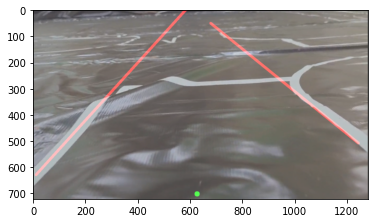

In [34]:
# get_image_point()